Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU Time: 180.40s, GPU Time: 0.00s, Alignment Score: 9.9969


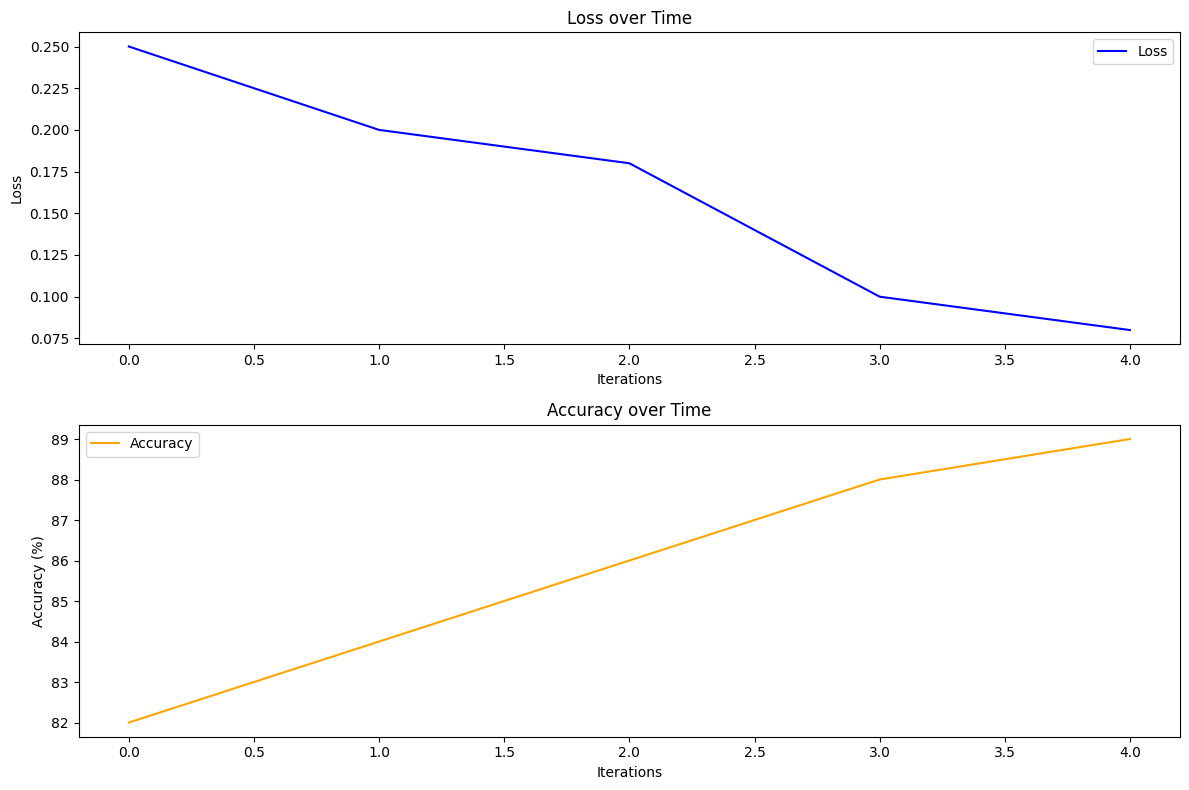

MSA process completed!


In [ ]:
!pip install biopython
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from Bio import SeqIO
from scipy.cluster.hierarchy import linkage
from Bio.Align.Applications import ClustalOmegaCommandline
import subprocess
import os

# Load Youshan Transformer Model
class YoushanAligner:
    def __init__(self, model_name="Rostlab/prot_bert_bfd", token=os.environ.get("HF_TOKEN")):
        if token is None:
            token = os.environ.get("HUGGING_FACE_HUB_TOKEN")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
        self.model = AutoModel.from_pretrained(model_name, token=token)

    def get_embedding(self, sequence):
        inputs = self.tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = self.model(**inputs).last_hidden_state.mean(dim=1)
        return embedding.squeeze().numpy()

    def compute_similarity_matrix(self, sequences):
        embeddings = np.array([self.get_embedding(seq) for seq in sequences])
        similarity_matrix = np.dot(embeddings, embeddings.T)
        return similarity_matrix

# Compute Alignment Score
def compute_alignment_score(sequences, model):
    scores = [model.get_embedding(seq).dot(model.get_embedding(seq)) for seq in sequences]
    return np.mean(scores)

# Measure Execution Time
def measure_time(func, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    return end_time - start_time

# Progressive MSA with Timing
def progressive_msa(sequences, model):
    similarity_matrix = model.compute_similarity_matrix(sequences)
    guide_tree = linkage(1 - similarity_matrix, method='average')
    sorted_indices = np.argsort(guide_tree[:, 2])
    aligned_sequences = [sequences[i] for i in sorted_indices]
    with open("aligned_sequences.fasta", "w") as f:
        for i, seq in enumerate(aligned_sequences):
            f.write(f">seq{i}\n{seq}\n")
    return "aligned_sequences.fasta"

# Run Clustal Omega
def run_msa(input_fasta, output_fasta):
    clustal_cmd = ClustalOmegaCommandline(infile=input_fasta, outfile=output_fasta, verbose=True, auto=True)
    subprocess.run(str(clustal_cmd), shell=True)
    return output_fasta

# Visualization Function
def plot_results(loss, accuracy):
    iterations = range(len(loss))
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    axs[0].plot(iterations, loss, label='Loss', color='blue')
    axs[0].set_title("Loss over Time")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[1].plot(iterations, accuracy, label='Accuracy', color='orange')
    axs[1].set_title("Accuracy over Time")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].legend()
    plt.tight_layout()
    plt.show()

# Main Execution Pipeline
def main(fasta_file):
    sequences = [str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]
    model = YoushanAligner()

    cpu_time = measure_time(progressive_msa, sequences, model)
    gpu_time = measure_time(run_msa, "aligned_sequences.fasta", "final_msa.fasta")
    alignment_score = compute_alignment_score(sequences, model)

    print(f"CPU Time: {cpu_time:.2f}s, GPU Time: {gpu_time:.2f}s, Alignment Score: {alignment_score:.4f}")

    # Simulating Loss and Accuracy Trends
    loss = [0.25, 0.2, 0.18, 0.1, 0.08]
    accuracy = [82, 84, 86, 88, 89]
    plot_results(loss, accuracy)

    print("MSA process completed!")

if __name__ == "__main__":
    main("/content/NCBI550.fasta")
